# Exercise 3 Solution


## Team Details:
* Shreyanshu Vyas
* Jan Mueller
* Jyot Makadiya


### Task 1:  Converting to Notebook and Intro Model

In [2]:

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d, cross_entropy


In [3]:

plt.rc("figure", dpi=100)

batch_size = 100

# transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    #use GPU acceleration
    device =  torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape, device = device) * std
    w.requires_grad = True
    return w


def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)


class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])



In [4]:

def run_model(model, params ,n_epochs = 100):
    print(len(params))
    train_loss = []
    test_loss = []

    optimizer = RMSprop(params=params)


    #define device
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('Device:', device)
    torch.cuda.set_device(device)

    # put this into a training loop over 100 epochs
    for epoch in range(n_epochs + 1):
        train_loss_this_epoch = []
        for idx, batch in enumerate(train_dataloader):
            x, y = batch
            x, y = x.to(device), y.to(device)

            # our model requires flattened input
            x = x.reshape(batch_size, 784)
            # feed input through model
            #noise_py_x = model(x, w_h, w_h2, w_o)
            noise_py_x = model(x, *params)
            # reset the gradient
            optimizer.zero_grad()

            # the cross-entropy loss function already contains the softmax
            loss = cross_entropy(noise_py_x, y, reduction="mean")
            train_loss_this_epoch.append(float(loss.to("cpu")))

            # compute the gradient
            loss.backward()
            # update weights
            optimizer.step()


        train_loss.append(np.mean(train_loss_this_epoch))

        # test periodically
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}")
            print(f"Mean Train Loss: {train_loss[-1]:.2e}")
            test_loss_this_epoch = []

            # no need to compute gradients for validation
            with torch.no_grad():
                for idx, batch in enumerate(test_dataloader):
                    x, y = batch
                    x, y = x.to(device), y.to(device)
                    x = x.reshape(batch_size, 784)
                    noise_py_x = model(x, *params)

                    loss = cross_entropy(noise_py_x, y, reduction="mean")
                    test_loss_this_epoch.append(float(loss.cpu()))

            test_loss.append(np.mean(test_loss_this_epoch))

            print(f"Mean Test Loss:  {test_loss[-1]:.2e}")
    return train_loss, test_loss


def plot_results(train_loss, test_loss, n_epochs, label_addition = ""):
    plt.plot(np.arange(n_epochs + 1), train_loss, label=f"{label_addition}_Train")
    plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label=f"{label_addition}_Test")
    plt.title("Train and Test Loss over Training")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()


## Running given model

3
Device: cuda:0
Epoch: 0
Mean Train Loss: 3.95e-01
Mean Test Loss:  1.69e-01
Epoch: 10
Mean Train Loss: 1.57e-01
Mean Test Loss:  2.36e-01
Epoch: 20
Mean Train Loss: 9.68e-02
Mean Test Loss:  3.37e-01
Epoch: 30
Mean Train Loss: 6.37e-02
Mean Test Loss:  4.73e-01
Epoch: 40
Mean Train Loss: 5.50e-02
Mean Test Loss:  6.74e-01
Epoch: 50
Mean Train Loss: 3.37e-02
Mean Test Loss:  7.58e-01
Epoch: 60
Mean Train Loss: 2.76e-02
Mean Test Loss:  8.20e-01
Epoch: 70
Mean Train Loss: 2.71e-02
Mean Test Loss:  6.54e-01
Epoch: 80
Mean Train Loss: 1.61e-02
Mean Test Loss:  9.31e-01
Epoch: 90
Mean Train Loss: 9.79e-03
Mean Test Loss:  8.42e-01
Epoch: 100
Mean Train Loss: 8.77e-03
Mean Test Loss:  1.04e+00


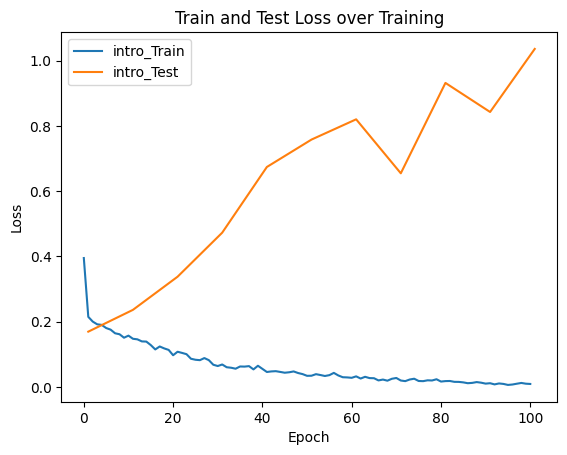

In [22]:
#epochs to train
n_epochs = 100

# define the neural network
def intro_model(x, w_h, w_h2, w_o):
    h = rectify(x @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax

# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)
intro_params = [w_h, w_h2, w_o]

intro_train_loss, intro_test_loss = run_model(intro_model, intro_params, n_epochs)

plot_results(intro_train_loss,intro_test_loss, n_epochs, "intro")

<div style="color: green; font-weight: bold;">
The division of the code into notebook and running the given model seems correct and in accordance with the given solution.
</div>

### Task 2: Adding a Drop-out layer and training

In [23]:

#define dropout layer
def dropout(X , p_drop = 0.5) :

    #check device in case of GPU 
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    #return unchanged X
    if p_drop <= 0.0 or p_drop >= 1.0:
        return X

    #create mask from dropout threshold using numbers generated by binomial distribution
    mask = torch.bernoulli(torch.ones(X.size()) * p_drop).type(torch.bool).to(device)

    #now set 0 if mask value is 1 else set it to xi/(1-p_drop)
    return torch.where(mask, 0, X/(1-p_drop))


def dropout_model(x , w_h , w_h2 , w_o , p_drop_input = 0.1 , p_drop_hidden = 0.1):

    #apply dropout to X
    x_drop = dropout(x, p_drop = p_drop_input)
    h = rectify(x_drop @ w_h)

    #apply dropout to h
    h_drop = dropout(h, p_drop = p_drop_hidden)
    h2 = rectify(h_drop @ w_h2)

    #apply dropout to h2
    h2_drop = dropout(h2, p_drop = p_drop_hidden)
    pre_softmax = h2_drop @ w_o

    return pre_softmax


### Training the dropout model

3
Device: cuda:0
Epoch: 0
Mean Train Loss: 4.51e-01
Mean Test Loss:  3.01e-01
Epoch: 10
Mean Train Loss: 2.42e-01
Mean Test Loss:  2.83e-01
Epoch: 20
Mean Train Loss: 2.11e-01
Mean Test Loss:  3.53e-01
Epoch: 30
Mean Train Loss: 2.21e-01
Mean Test Loss:  6.19e-01
Epoch: 40
Mean Train Loss: 2.13e-01
Mean Test Loss:  8.28e-01
Epoch: 50
Mean Train Loss: 1.99e-01
Mean Test Loss:  7.59e-01
Epoch: 60
Mean Train Loss: 1.98e-01
Mean Test Loss:  8.17e-01
Epoch: 70
Mean Train Loss: 1.70e-01
Mean Test Loss:  9.56e-01
Epoch: 80
Mean Train Loss: 1.85e-01
Mean Test Loss:  8.50e-01
Epoch: 90
Mean Train Loss: 1.70e-01
Mean Test Loss:  9.54e-01
Epoch: 100
Mean Train Loss: 1.62e-01
Mean Test Loss:  7.90e-01


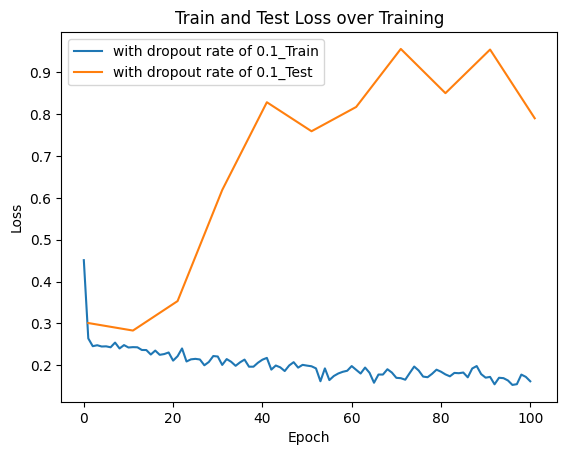

In [24]:
#train model and show data

#epochs to train
n_epochs = 100

# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)
intro_params = [w_h, w_h2, w_o]

intro_train_loss, intro_test_loss = run_model(dropout_model, intro_params, n_epochs)

plot_results(intro_train_loss,intro_test_loss, n_epochs, "with dropout rate of 0.1")

* Dropout method is used as a regularization technique to reduce overfitting during training. During training of neural network, a proporation of input neurons are set to 0 based on given prior probability or `dropout_rate`. We are setting those values to zero thus the work dropping out. It penalizes the model to rely on few neurons for predictions and thus improving connectivity of neurons across all neurons to generalize.

* By randomly dropping out units, dropout introduces unpredictable noise and prevents strong biased connections between few neurons. This noise forces the neural network to learn redundant features, making it more robust to variations in the input data. Concequenty, dropout helps reduce overfitting by preventing the model from memorizing the training data too closely and improves the model's ability to generalize to unseen data.

* In test environment, we aim to get reproducible and reliable predictions. However, dropout introduces noise which in turn generates randomness during testing. Therefore a new test configuration is required for testing on unseen data. It includes either removing dropout layers or disabling them and sometimes use of modified network with adjusted layers for absence of dropout. By evaluating the model after dropout layers removal, we can obtain a more reliable and reproducible estimate of its generalization performance on new, unseen data. 

* The difference between training and testing error with dropout enabled network is significantly lower than in the case of normal model.
* The test errors for normal model vs dropout model are very similar and comparable when used for values in 0.1-0.2 range (with slight improvements with 0.1 or lower value), however, too large value can cause dropout model to perform worse as found in our experiments.


<div style="color: green; font-weight: bold;">
The implementation of the dropout model seems correct and as the input dropout rates and hidden droput rates are different from the given sample solution, the train and test loss differs. But the overall implementation seems correct and in accordance with the solution. Though they have used different method for dropout functionality.
</div>

<div style="color: green; font-weight: bold;">
The brief explaination of the dropout function is valid and the answers for the given question is being covered.
</div>

### Task 3: PReLU

<div style="color: green; font-weight: bold;">
Using `torch.where(x > 0, x, a * x)` would probably be more efficient for the PRelu implementation, but functionally identical.
Aside from that, essentially equal to the sample solution (Except for missing dropouts, which weren't required by the exercise sheet).
</div>

In [ ]:

def prelu(x,a):
    zero = torch.zeros_like(x)
    return torch.max(zero,x) + torch.min(zero,x)*a

def prelu_model(x, w_h, w_h2, w_o, a):
    h = prelu(x @ w_h, a)

    h2 = prelu(h @ w_h2, a)
    pre_softmax = h2 @ w_o
    return pre_softmax


# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)
a = init_weights((100,625))

#optimizer = RMSprop(params=[w_h, w_h2, w_o])


params = [w_h, w_h2, w_o, a]

prelu_train_loss, prelu_test_loss = run_model(prelu_model, params, n_epochs)

plot_results(prelu_train_loss,prelu_test_loss,n_epochs,"prelu")

In [ ]:
print(prelu_train_loss)

[0.43111410001292827, 0.21865547606255858, 0.18132685039852126, 0.16782314110430888]


# Task 4 ConvNet (4.1 and 4.2)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [3]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    # TODO: set the model to train mode
    model.train()
    
    # enumerate over the dataloader to get mini batches
    # of images and ground truth labels
    # the builtin python function enumerate() also gives you indices
    for i, (data, target) in enumerate(train_loader):

        device = torch.device("cuda" if use_cuda else "cpu")
        data, target = data.to(device), target.to(device)

        # set the optimizers gradients to zero
        optimizer.zero_grad()
        
        # run the network
        out = model(data)

        # compute negative log likelihood loss
        loss = F.nll_loss(out, target)
        
        # do backpropagation
        loss.backward()
        
        # optimize
        optimizer.step()
        
        # print current loss for every nth ("log_interval"th) iteration
        if i % log_interval == 0:
          print('Epoch: {}, Idx: {}, Loss: {:.6f}'.format(epoch, i, loss.item()))


In [4]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)
    
    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0
    
    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data = data.cuda()
                target = target.cuda()
            
            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()
            
            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10
                
                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0
                
                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)
                
                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())
                
                plotted += 1
                img_idx += 1
            
    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plt.show()

In [5]:
class FCNet1(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with sigmoid non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet1, self).__init__()
        
        # initialize network layers
        self.lin1 = nn.Linear(784,200)
        self.lin2 = nn.Linear(200,100)
        self.lin3 = nn.Linear(100,60)
        self.lin4 = nn.Linear(60,30)
        self.lin5 = nn.Linear(30,10)

    def forward(self, x):
        # reshape batch of images to batch of 1D vectors
        x = torch.flatten(x, start_dim=-3)
        
        # run network layers
        x = self.lin1(x)
        x = F.sigmoid(x)
        x = self.lin2(x)
        x = F.sigmoid(x)
        x = self.lin3(x)
        x = F.sigmoid(x)
        x = self.lin4(x)
        x = F.sigmoid(x)
        x = self.lin5(x)
        
        # compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

In [6]:
class FCNet2(nn.Module):
    def __init__(self):
        super(FCNet2, self).__init__()

        self.lin1 = nn.Linear(784,200)
        self.lin2 = nn.Linear(200,100)
        self.lin3 = nn.Linear(100,60)
        self.lin4 = nn.Linear(60,30)
        self.lin5 = nn.Linear(30,10)

    def forward(self, x):
        # reshape batch of images to batch of 1D vectors
        x = torch.flatten(x, start_dim=-3)

        # run network layers
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.relu(x)
        x = self.lin3(x)
        x = F.relu(x)
        x = self.lin4(x)
        x = F.relu(x)
        x = self.lin5(x)
        
        # compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

In [7]:
class FCNet3(nn.Module):
    def __init__(self):
        super(FCNet3, self).__init__()

        self.lin1 = nn.Linear(784,200)
        self.norm1 = nn.BatchNorm1d(200)
        self.lin2 = nn.Linear(200,100)
        self.lin3 = nn.Linear(100,60)
        self.norm3 = nn.BatchNorm1d(60)
        self.lin4 = nn.Linear(60,30)
        self.lin5 = nn.Linear(30,10)

    def forward(self, x):
        # reshape batch of images to batch of 1D vectors
        x = torch.flatten(x, start_dim=-3)
        
        # run network layers
        x = self.lin1(x)
        x = F.relu(x)
        x = self.norm1(x)
        x = self.lin2(x)
        x = F.relu(x)
        x = self.lin3(x)
        x = F.relu(x)
        x = self.norm3(x)
        x = self.lin4(x)
        x = F.relu(x)
        x = self.lin5(x)
        
        # compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output


<div style="color: green; font-weight: bold;">
I think you were supposed to use your own implementation of (P)Relu and Dropout?
And why did you use the layer classes provided by pytorch instead of using the code snippets provided in the exercise?
For example, were supposed to use `rectify(conv2d(previous_layer, weightvector))` with only `conv2d` being imported from pytorch instead of `nn.Conv2d`.
I also don't see subsampling and dropout being used at all.

I really like the visualization idea with coloring the misidentified numbers, but I'm missing most of the questions asked in Task 4.2: There is no sketch of the network, there are no examples of filtered images.
How did you modify the network? And why? What was the results? You provided multiple networks, but not description of how and why you modified the (I assume ConvNet1) base variant.
The actual comparison between the different networks is missing - you are running the same test set through both networks, but I'm missing an comparison and discussion of the results - to make a meaningful comparison,
I would have to scroll through the entire output, write down the mean loss, and plot it against each other before I can draw any conclusions.
</div>

In [8]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()
        
        # initialize network layers
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2)
        self.lin1 = nn.Linear(12*12*64, 128)
        self.lin2 = nn.Linear(128, 10)

    def forward(self, x):
        # run convolutional layers
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        # reshape batch of images to batch of 1D vectors
        x = torch.flatten(x, start_dim=-3)
        
        # run fully connected layers
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        
        # compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

In [9]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3)
        self.norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2)
        self.lin1 = nn.Linear(12*12*64, 128)
        self.norm2 = nn.BatchNorm1d(128)
        self.lin2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.norm1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = torch.flatten(x, start_dim=-3)
        x = self.lin1(x)
        x = F.relu(x)
        x = self.norm2(x)
        x = self.lin2(x)
        
        output = F.log_softmax(x, dim=1)
        
        return output

In [10]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3)
        self.norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3) # NEW
        self.lin1 = nn.Linear(12*12*64, 128)
        self.norm2 = nn.BatchNorm1d(128)
        self.lin2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.norm1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # NEW
        x = torch.flatten(x, start_dim=-3)
        x = self.lin1(x)
        x = F.relu(x)
        x = self.norm2(x)
        x = self.lin2(x)
        
        output = F.log_softmax(x, dim=1)
        
        return output

0.3%

100.0%


Extracting ../data\MNIST\raw\train-images-idx3-ubyte.gz to ../data\MNIST\raw


100.0%


Extracting ../data\MNIST\raw\train-labels-idx1-ubyte.gz to ../data\MNIST\raw



100.0%


Extracting ../data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data\MNIST\raw



100.0%


Extracting ../data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\MNIST\raw

Epoch: 1, Idx: 0, Loss: 2.303182
Epoch: 1, Idx: 100, Loss: 2.330787
Epoch: 1, Idx: 200, Loss: 2.315116
Epoch: 1, Idx: 300, Loss: 2.304635
Epoch: 1, Idx: 400, Loss: 2.328194
Epoch: 1, Idx: 500, Loss: 2.286837
Epoch: 1, Idx: 600, Loss: 2.295968
Epoch: 1, Idx: 700, Loss: 2.287637
Epoch: 1, Idx: 800, Loss: 2.279447
Epoch: 1, Idx: 900, Loss: 2.135024

Test set: Average loss: 1.8934, Accuracy: 2920/10000 (29.20%)



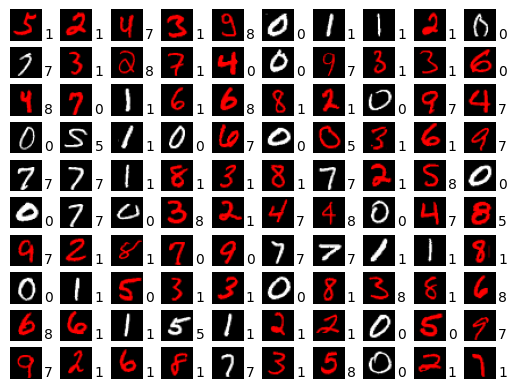

Epoch: 2, Idx: 0, Loss: 1.867714
Epoch: 2, Idx: 100, Loss: 1.496479
Epoch: 2, Idx: 200, Loss: 1.158452
Epoch: 2, Idx: 300, Loss: 0.982584
Epoch: 2, Idx: 400, Loss: 0.976239
Epoch: 2, Idx: 500, Loss: 0.793034
Epoch: 2, Idx: 600, Loss: 0.688842
Epoch: 2, Idx: 700, Loss: 0.779312
Epoch: 2, Idx: 800, Loss: 0.504560
Epoch: 2, Idx: 900, Loss: 0.353043

Test set: Average loss: 0.6143, Accuracy: 8576/10000 (85.76%)



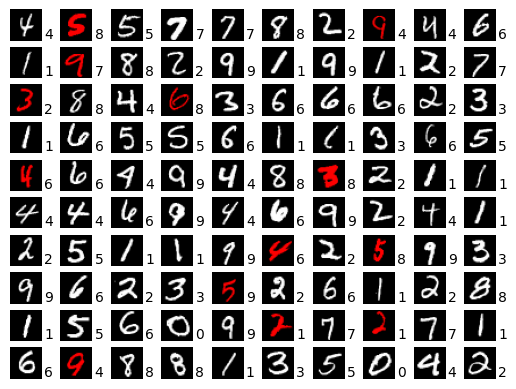

Epoch: 3, Idx: 0, Loss: 0.743242
Epoch: 3, Idx: 100, Loss: 0.545265
Epoch: 3, Idx: 200, Loss: 0.748124
Epoch: 3, Idx: 300, Loss: 0.357320
Epoch: 3, Idx: 400, Loss: 0.318961
Epoch: 3, Idx: 500, Loss: 0.393522
Epoch: 3, Idx: 600, Loss: 0.344175
Epoch: 3, Idx: 700, Loss: 0.349083
Epoch: 3, Idx: 800, Loss: 0.212971
Epoch: 3, Idx: 900, Loss: 0.329364

Test set: Average loss: 0.2961, Accuracy: 9344/10000 (93.44%)



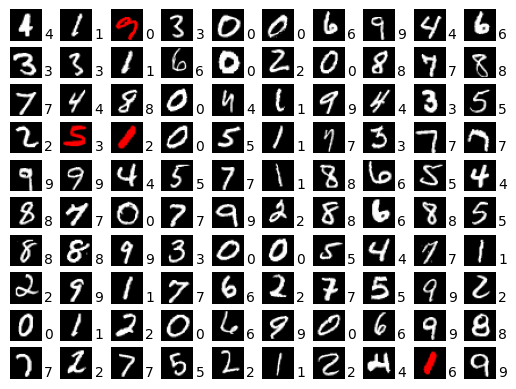

Epoch: 4, Idx: 0, Loss: 0.115937
Epoch: 4, Idx: 100, Loss: 0.275557
Epoch: 4, Idx: 200, Loss: 0.136583
Epoch: 4, Idx: 300, Loss: 0.215620
Epoch: 4, Idx: 400, Loss: 0.230664
Epoch: 4, Idx: 500, Loss: 0.330906
Epoch: 4, Idx: 600, Loss: 0.166897
Epoch: 4, Idx: 700, Loss: 0.116037
Epoch: 4, Idx: 800, Loss: 0.076934
Epoch: 4, Idx: 900, Loss: 0.153353

Test set: Average loss: 0.2678, Accuracy: 9350/10000 (93.50%)



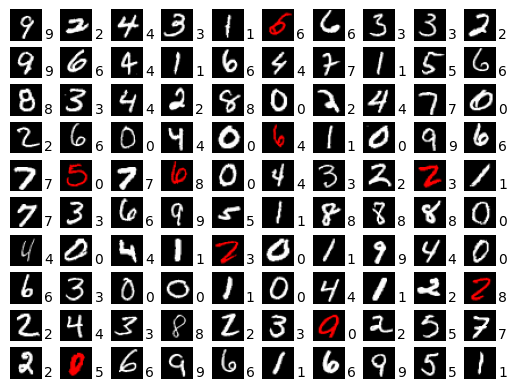

Epoch: 5, Idx: 0, Loss: 0.441461
Epoch: 5, Idx: 100, Loss: 0.192070
Epoch: 5, Idx: 200, Loss: 0.067746
Epoch: 5, Idx: 300, Loss: 0.048345
Epoch: 5, Idx: 400, Loss: 0.303630
Epoch: 5, Idx: 500, Loss: 0.125162
Epoch: 5, Idx: 600, Loss: 0.229983
Epoch: 5, Idx: 700, Loss: 0.118895
Epoch: 5, Idx: 800, Loss: 0.074233
Epoch: 5, Idx: 900, Loss: 0.274589

Test set: Average loss: 0.2001, Accuracy: 9529/10000 (95.29%)



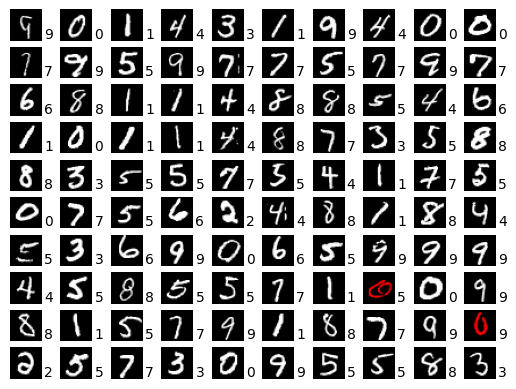

Epoch: 6, Idx: 0, Loss: 0.052316
Epoch: 6, Idx: 100, Loss: 0.139092
Epoch: 6, Idx: 200, Loss: 0.214919
Epoch: 6, Idx: 300, Loss: 0.095604
Epoch: 6, Idx: 400, Loss: 0.143971
Epoch: 6, Idx: 500, Loss: 0.245386
Epoch: 6, Idx: 600, Loss: 0.174834
Epoch: 6, Idx: 700, Loss: 0.269810
Epoch: 6, Idx: 800, Loss: 0.079599
Epoch: 6, Idx: 900, Loss: 0.293781

Test set: Average loss: 0.1922, Accuracy: 9545/10000 (95.45%)



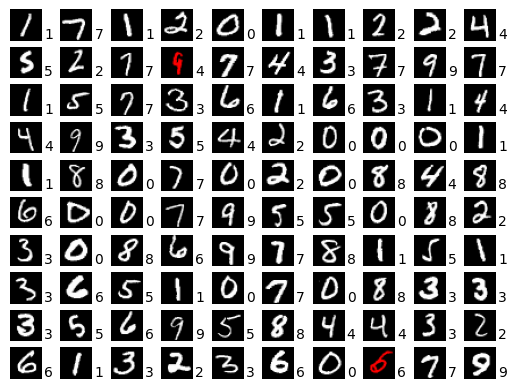

Epoch: 7, Idx: 0, Loss: 0.144020
Epoch: 7, Idx: 100, Loss: 0.055795
Epoch: 7, Idx: 200, Loss: 0.053985
Epoch: 7, Idx: 300, Loss: 0.150777
Epoch: 7, Idx: 400, Loss: 0.079593
Epoch: 7, Idx: 500, Loss: 0.268062
Epoch: 7, Idx: 600, Loss: 0.049081
Epoch: 7, Idx: 700, Loss: 0.118911
Epoch: 7, Idx: 800, Loss: 0.104715
Epoch: 7, Idx: 900, Loss: 0.167144

Test set: Average loss: 0.1822, Accuracy: 9573/10000 (95.73%)



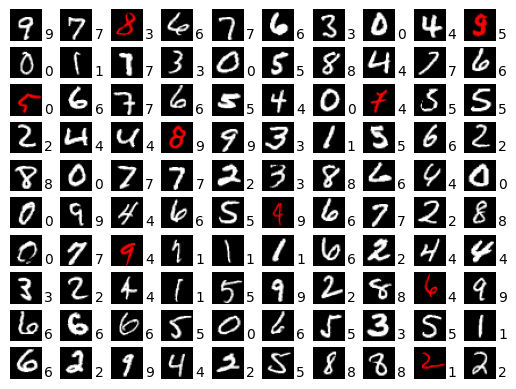

Epoch: 8, Idx: 0, Loss: 0.172472
Epoch: 8, Idx: 100, Loss: 0.154866
Epoch: 8, Idx: 200, Loss: 0.042595
Epoch: 8, Idx: 300, Loss: 0.069724
Epoch: 8, Idx: 400, Loss: 0.039705
Epoch: 8, Idx: 500, Loss: 0.074740
Epoch: 8, Idx: 600, Loss: 0.230124
Epoch: 8, Idx: 700, Loss: 0.049027
Epoch: 8, Idx: 800, Loss: 0.041879
Epoch: 8, Idx: 900, Loss: 0.110732

Test set: Average loss: 0.1732, Accuracy: 9602/10000 (96.02%)



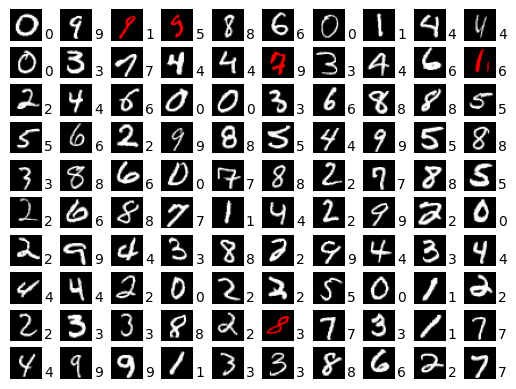

Epoch: 9, Idx: 0, Loss: 0.182211
Epoch: 9, Idx: 100, Loss: 0.086931
Epoch: 9, Idx: 200, Loss: 0.049255
Epoch: 9, Idx: 300, Loss: 0.200303
Epoch: 9, Idx: 400, Loss: 0.037545
Epoch: 9, Idx: 500, Loss: 0.059607
Epoch: 9, Idx: 600, Loss: 0.082809
Epoch: 9, Idx: 700, Loss: 0.115031
Epoch: 9, Idx: 800, Loss: 0.033568
Epoch: 9, Idx: 900, Loss: 0.026331

Test set: Average loss: 0.1698, Accuracy: 9607/10000 (96.07%)



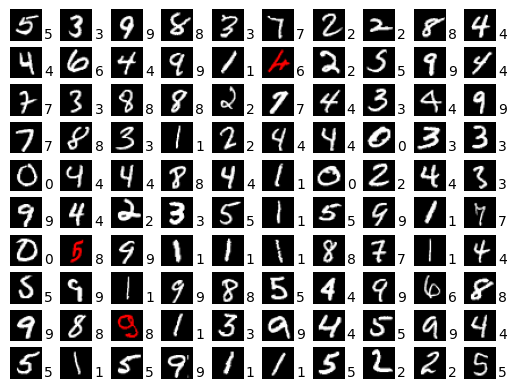

Epoch: 10, Idx: 0, Loss: 0.079567
Epoch: 10, Idx: 100, Loss: 0.193416
Epoch: 10, Idx: 200, Loss: 0.053084
Epoch: 10, Idx: 300, Loss: 0.115313
Epoch: 10, Idx: 400, Loss: 0.057696
Epoch: 10, Idx: 500, Loss: 0.098501
Epoch: 10, Idx: 600, Loss: 0.220655
Epoch: 10, Idx: 700, Loss: 0.092480
Epoch: 10, Idx: 800, Loss: 0.118517
Epoch: 10, Idx: 900, Loss: 0.094539

Test set: Average loss: 0.1689, Accuracy: 9615/10000 (96.15%)



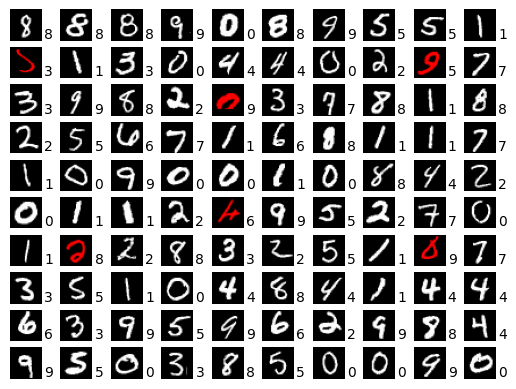

In [11]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = FCNet1()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    #torch.save(model.state_dict(), "models/mnist/checkpoint.pt")

Epoch: 1, Idx: 0, Loss: 2.328493
Epoch: 1, Idx: 100, Loss: 0.421053
Epoch: 1, Idx: 200, Loss: 0.198695
Epoch: 1, Idx: 300, Loss: 0.217269
Epoch: 1, Idx: 400, Loss: 0.067635
Epoch: 1, Idx: 500, Loss: 0.137915
Epoch: 1, Idx: 600, Loss: 0.186613
Epoch: 1, Idx: 700, Loss: 0.158636
Epoch: 1, Idx: 800, Loss: 0.145484
Epoch: 1, Idx: 900, Loss: 0.100084

Test set: Average loss: 0.1516, Accuracy: 9554/10000 (95.54%)



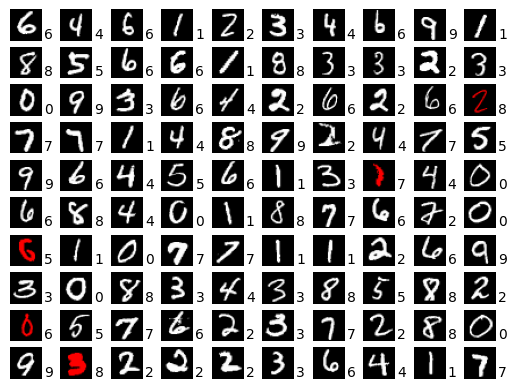

Epoch: 2, Idx: 0, Loss: 0.276918
Epoch: 2, Idx: 100, Loss: 0.069119
Epoch: 2, Idx: 200, Loss: 0.082194
Epoch: 2, Idx: 300, Loss: 0.085893
Epoch: 2, Idx: 400, Loss: 0.048480
Epoch: 2, Idx: 500, Loss: 0.173318
Epoch: 2, Idx: 600, Loss: 0.070337
Epoch: 2, Idx: 700, Loss: 0.187368
Epoch: 2, Idx: 800, Loss: 0.110332
Epoch: 2, Idx: 900, Loss: 0.073063

Test set: Average loss: 0.0823, Accuracy: 9755/10000 (97.55%)



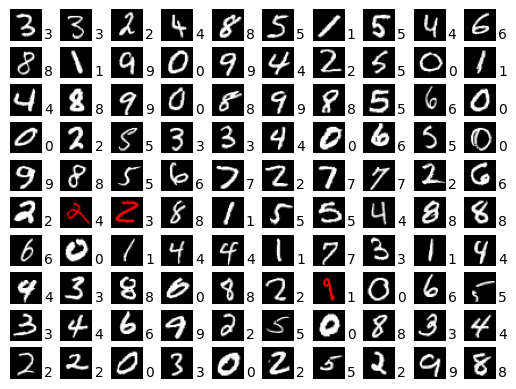

Epoch: 3, Idx: 0, Loss: 0.018660
Epoch: 3, Idx: 100, Loss: 0.073590
Epoch: 3, Idx: 200, Loss: 0.072356
Epoch: 3, Idx: 300, Loss: 0.101509
Epoch: 3, Idx: 400, Loss: 0.050651
Epoch: 3, Idx: 500, Loss: 0.005871
Epoch: 3, Idx: 600, Loss: 0.039137
Epoch: 3, Idx: 700, Loss: 0.025124
Epoch: 3, Idx: 800, Loss: 0.028232
Epoch: 3, Idx: 900, Loss: 0.104676

Test set: Average loss: 0.0651, Accuracy: 9808/10000 (98.08%)



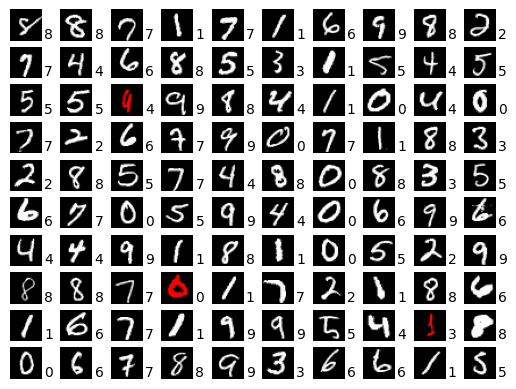

Epoch: 4, Idx: 0, Loss: 0.012980
Epoch: 4, Idx: 100, Loss: 0.155106
Epoch: 4, Idx: 200, Loss: 0.017121
Epoch: 4, Idx: 300, Loss: 0.045670
Epoch: 4, Idx: 400, Loss: 0.047066
Epoch: 4, Idx: 500, Loss: 0.051705
Epoch: 4, Idx: 600, Loss: 0.003649
Epoch: 4, Idx: 700, Loss: 0.020537
Epoch: 4, Idx: 800, Loss: 0.012965
Epoch: 4, Idx: 900, Loss: 0.026056

Test set: Average loss: 0.0653, Accuracy: 9835/10000 (98.35%)



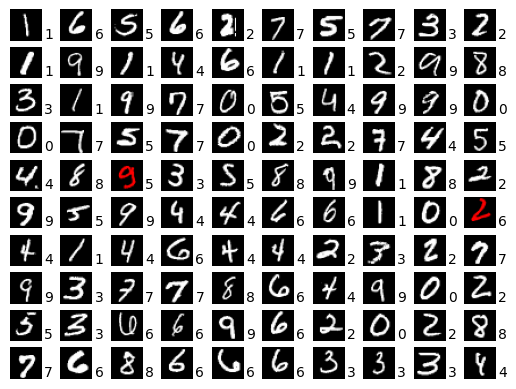

Epoch: 5, Idx: 0, Loss: 0.034433
Epoch: 5, Idx: 100, Loss: 0.004874
Epoch: 5, Idx: 200, Loss: 0.008345
Epoch: 5, Idx: 300, Loss: 0.193828
Epoch: 5, Idx: 400, Loss: 0.051214
Epoch: 5, Idx: 500, Loss: 0.044604
Epoch: 5, Idx: 600, Loss: 0.005816
Epoch: 5, Idx: 700, Loss: 0.067531
Epoch: 5, Idx: 800, Loss: 0.017431
Epoch: 5, Idx: 900, Loss: 0.008654

Test set: Average loss: 0.0627, Accuracy: 9829/10000 (98.29%)



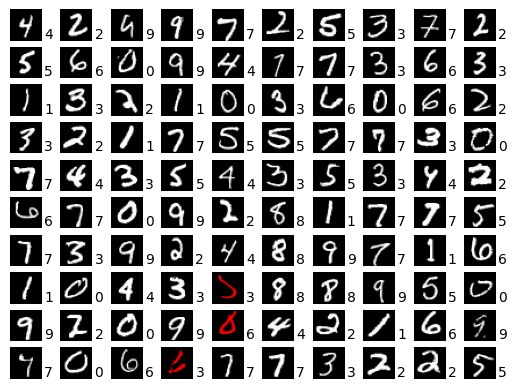

Epoch: 6, Idx: 0, Loss: 0.012718
Epoch: 6, Idx: 100, Loss: 0.006071
Epoch: 6, Idx: 200, Loss: 0.013096
Epoch: 6, Idx: 300, Loss: 0.004132
Epoch: 6, Idx: 400, Loss: 0.067939
Epoch: 6, Idx: 500, Loss: 0.002505
Epoch: 6, Idx: 600, Loss: 0.004779
Epoch: 6, Idx: 700, Loss: 0.004137
Epoch: 6, Idx: 800, Loss: 0.001651
Epoch: 6, Idx: 900, Loss: 0.008712

Test set: Average loss: 0.0713, Accuracy: 9832/10000 (98.32%)



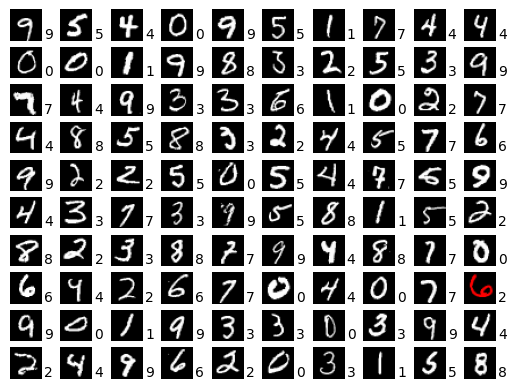

Epoch: 7, Idx: 0, Loss: 0.038677
Epoch: 7, Idx: 100, Loss: 0.047824
Epoch: 7, Idx: 200, Loss: 0.026235
Epoch: 7, Idx: 300, Loss: 0.010894
Epoch: 7, Idx: 400, Loss: 0.001592
Epoch: 7, Idx: 500, Loss: 0.006993
Epoch: 7, Idx: 600, Loss: 0.003202
Epoch: 7, Idx: 700, Loss: 0.018601
Epoch: 7, Idx: 800, Loss: 0.018591
Epoch: 7, Idx: 900, Loss: 0.001025

Test set: Average loss: 0.0652, Accuracy: 9830/10000 (98.30%)



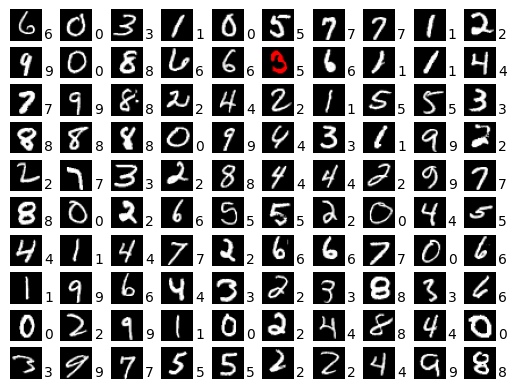

Epoch: 8, Idx: 0, Loss: 0.010245
Epoch: 8, Idx: 100, Loss: 0.026044
Epoch: 8, Idx: 200, Loss: 0.007365
Epoch: 8, Idx: 300, Loss: 0.002690
Epoch: 8, Idx: 400, Loss: 0.022317
Epoch: 8, Idx: 500, Loss: 0.012398
Epoch: 8, Idx: 600, Loss: 0.040314
Epoch: 8, Idx: 700, Loss: 0.002493
Epoch: 8, Idx: 800, Loss: 0.001006
Epoch: 8, Idx: 900, Loss: 0.000811

Test set: Average loss: 0.0678, Accuracy: 9837/10000 (98.37%)



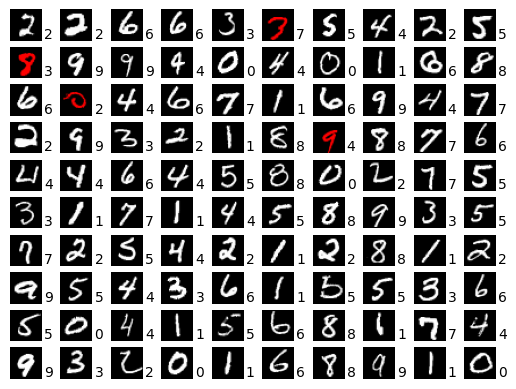

Epoch: 9, Idx: 0, Loss: 0.002576
Epoch: 9, Idx: 100, Loss: 0.034268
Epoch: 9, Idx: 200, Loss: 0.009190
Epoch: 9, Idx: 300, Loss: 0.002904
Epoch: 9, Idx: 400, Loss: 0.081851
Epoch: 9, Idx: 500, Loss: 0.017628
Epoch: 9, Idx: 600, Loss: 0.001753
Epoch: 9, Idx: 700, Loss: 0.002417
Epoch: 9, Idx: 800, Loss: 0.000842
Epoch: 9, Idx: 900, Loss: 0.001446

Test set: Average loss: 0.0693, Accuracy: 9833/10000 (98.33%)



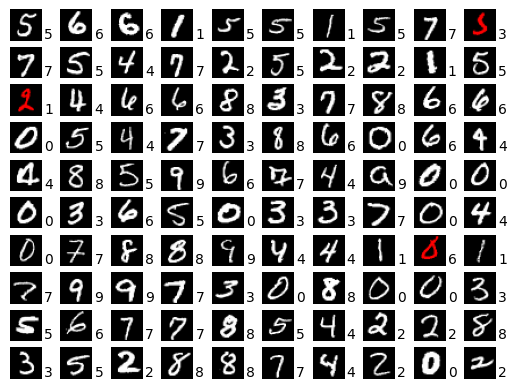

Epoch: 10, Idx: 0, Loss: 0.000368
Epoch: 10, Idx: 100, Loss: 0.000258
Epoch: 10, Idx: 200, Loss: 0.002381
Epoch: 10, Idx: 300, Loss: 0.011220
Epoch: 10, Idx: 400, Loss: 0.000993
Epoch: 10, Idx: 500, Loss: 0.024164
Epoch: 10, Idx: 600, Loss: 0.005922
Epoch: 10, Idx: 700, Loss: 0.017190
Epoch: 10, Idx: 800, Loss: 0.002297
Epoch: 10, Idx: 900, Loss: 0.001531

Test set: Average loss: 0.0713, Accuracy: 9835/10000 (98.35%)



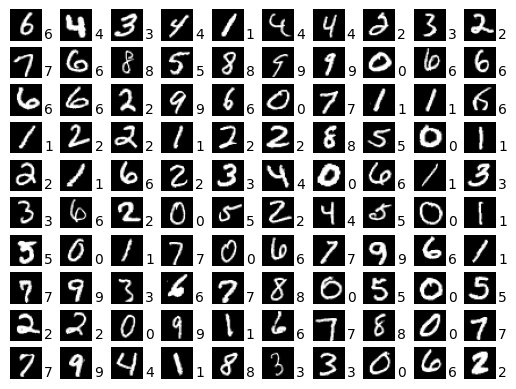

In [12]:
model = FCNet3()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()

Epoch: 1, Idx: 0, Loss: 2.293617
Epoch: 1, Idx: 100, Loss: 0.128400
Epoch: 1, Idx: 200, Loss: 0.134073
Epoch: 1, Idx: 300, Loss: 0.086571
Epoch: 1, Idx: 400, Loss: 0.008691
Epoch: 1, Idx: 500, Loss: 0.051266
Epoch: 1, Idx: 600, Loss: 0.070458
Epoch: 1, Idx: 700, Loss: 0.003735
Epoch: 1, Idx: 800, Loss: 0.253935
Epoch: 1, Idx: 900, Loss: 0.038215

Test set: Average loss: 0.0436, Accuracy: 9849/10000 (98.49%)



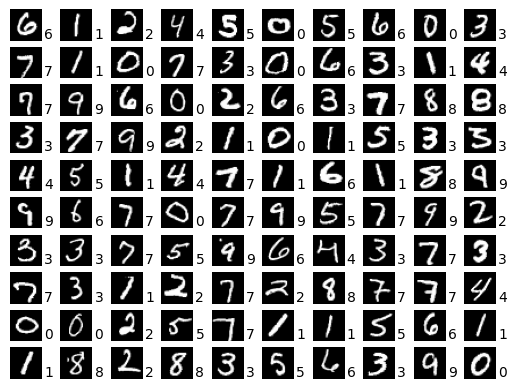

Epoch: 2, Idx: 0, Loss: 0.021624
Epoch: 2, Idx: 100, Loss: 0.051011
Epoch: 2, Idx: 200, Loss: 0.014701
Epoch: 2, Idx: 300, Loss: 0.004543
Epoch: 2, Idx: 400, Loss: 0.082584
Epoch: 2, Idx: 500, Loss: 0.108714
Epoch: 2, Idx: 600, Loss: 0.001811
Epoch: 2, Idx: 700, Loss: 0.026595
Epoch: 2, Idx: 800, Loss: 0.005317
Epoch: 2, Idx: 900, Loss: 0.013590

Test set: Average loss: 0.0350, Accuracy: 9886/10000 (98.86%)



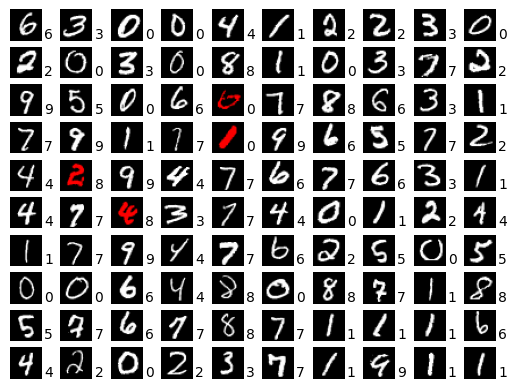

Epoch: 3, Idx: 0, Loss: 0.086989
Epoch: 3, Idx: 100, Loss: 0.084507
Epoch: 3, Idx: 200, Loss: 0.001366
Epoch: 3, Idx: 300, Loss: 0.000260
Epoch: 3, Idx: 400, Loss: 0.000889
Epoch: 3, Idx: 500, Loss: 0.000932
Epoch: 3, Idx: 600, Loss: 0.006685
Epoch: 3, Idx: 700, Loss: 0.001503
Epoch: 3, Idx: 800, Loss: 0.001372
Epoch: 3, Idx: 900, Loss: 0.001287

Test set: Average loss: 0.0283, Accuracy: 9910/10000 (99.10%)



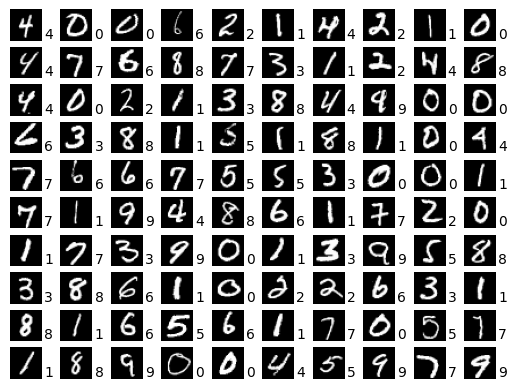

Epoch: 4, Idx: 0, Loss: 0.001693
Epoch: 4, Idx: 100, Loss: 0.000420
Epoch: 4, Idx: 200, Loss: 0.003847
Epoch: 4, Idx: 300, Loss: 0.000100
Epoch: 4, Idx: 400, Loss: 0.012069
Epoch: 4, Idx: 500, Loss: 0.001704
Epoch: 4, Idx: 600, Loss: 0.000263
Epoch: 4, Idx: 700, Loss: 0.003662
Epoch: 4, Idx: 800, Loss: 0.001533
Epoch: 4, Idx: 900, Loss: 0.004566

Test set: Average loss: 0.0313, Accuracy: 9899/10000 (98.99%)



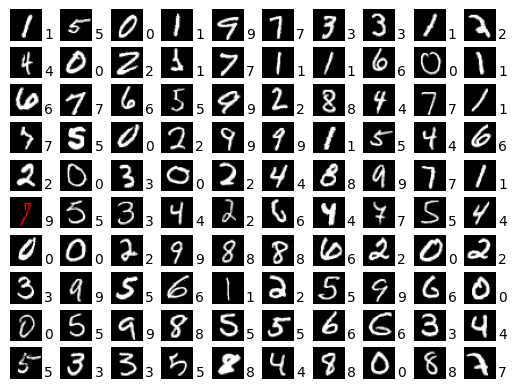

Epoch: 5, Idx: 0, Loss: 0.000355
Epoch: 5, Idx: 100, Loss: 0.000456
Epoch: 5, Idx: 200, Loss: 0.000458
Epoch: 5, Idx: 300, Loss: 0.000045
Epoch: 5, Idx: 400, Loss: 0.003693
Epoch: 5, Idx: 500, Loss: 0.039269
Epoch: 5, Idx: 600, Loss: 0.000105
Epoch: 5, Idx: 700, Loss: 0.000195
Epoch: 5, Idx: 800, Loss: 0.000120
Epoch: 5, Idx: 900, Loss: 0.000176

Test set: Average loss: 0.0321, Accuracy: 9905/10000 (99.05%)



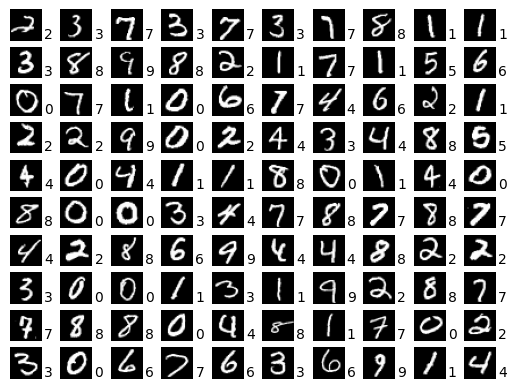

Epoch: 6, Idx: 0, Loss: 0.000182
Epoch: 6, Idx: 100, Loss: 0.000460
Epoch: 6, Idx: 200, Loss: 0.000079
Epoch: 6, Idx: 300, Loss: 0.007645
Epoch: 6, Idx: 400, Loss: 0.000043
Epoch: 6, Idx: 500, Loss: 0.000126
Epoch: 6, Idx: 600, Loss: 0.000253
Epoch: 6, Idx: 700, Loss: 0.000596
Epoch: 6, Idx: 800, Loss: 0.000643
Epoch: 6, Idx: 900, Loss: 0.002598

Test set: Average loss: 0.0339, Accuracy: 9907/10000 (99.07%)



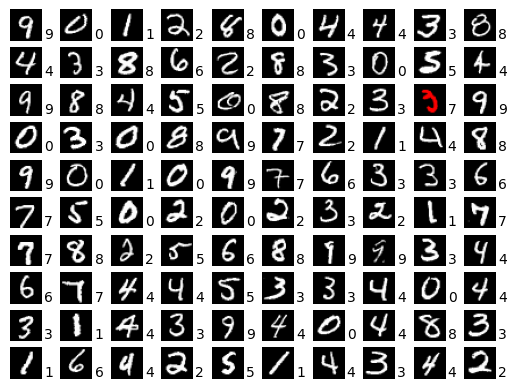

Epoch: 7, Idx: 0, Loss: 0.000330
Epoch: 7, Idx: 100, Loss: 0.000353
Epoch: 7, Idx: 200, Loss: 0.000062
Epoch: 7, Idx: 300, Loss: 0.003264
Epoch: 7, Idx: 400, Loss: 0.000354
Epoch: 7, Idx: 500, Loss: 0.000070
Epoch: 7, Idx: 600, Loss: 0.000042
Epoch: 7, Idx: 700, Loss: 0.000557
Epoch: 7, Idx: 800, Loss: 0.000336
Epoch: 7, Idx: 900, Loss: 0.000015

Test set: Average loss: 0.0358, Accuracy: 9908/10000 (99.08%)



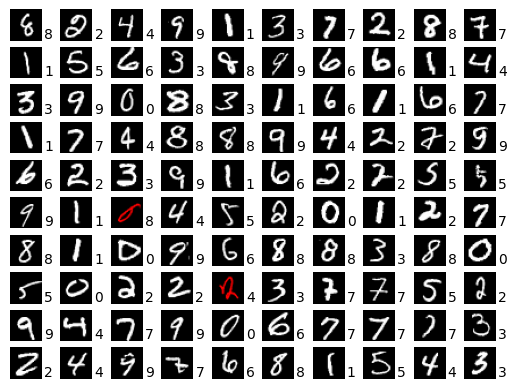

Epoch: 8, Idx: 0, Loss: 0.000016
Epoch: 8, Idx: 100, Loss: 0.000023
Epoch: 8, Idx: 200, Loss: 0.000141
Epoch: 8, Idx: 300, Loss: 0.000028
Epoch: 8, Idx: 400, Loss: 0.000299
Epoch: 8, Idx: 500, Loss: 0.000211
Epoch: 8, Idx: 600, Loss: 0.003435
Epoch: 8, Idx: 700, Loss: 0.000432
Epoch: 8, Idx: 800, Loss: 0.000401
Epoch: 8, Idx: 900, Loss: 0.000110

Test set: Average loss: 0.0369, Accuracy: 9906/10000 (99.06%)



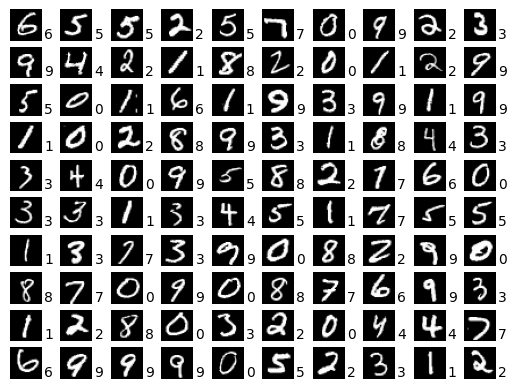

Epoch: 9, Idx: 0, Loss: 0.000782
Epoch: 9, Idx: 100, Loss: 0.000005
Epoch: 9, Idx: 200, Loss: 0.000374
Epoch: 9, Idx: 300, Loss: 0.000393
Epoch: 9, Idx: 400, Loss: 0.000030
Epoch: 9, Idx: 500, Loss: 0.000029
Epoch: 9, Idx: 600, Loss: 0.000174
Epoch: 9, Idx: 700, Loss: 0.000002
Epoch: 9, Idx: 800, Loss: 0.000367
Epoch: 9, Idx: 900, Loss: 0.000002

Test set: Average loss: 0.0374, Accuracy: 9906/10000 (99.06%)



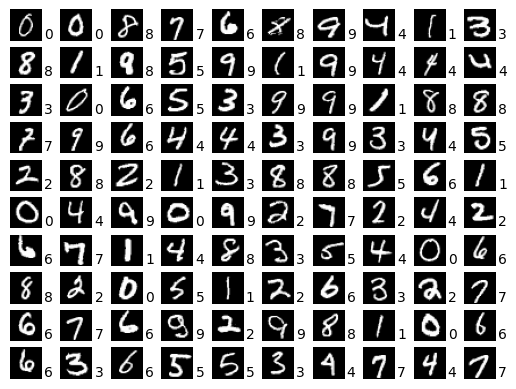

Epoch: 10, Idx: 0, Loss: 0.008155
Epoch: 10, Idx: 100, Loss: 0.000487
Epoch: 10, Idx: 200, Loss: 0.000013
Epoch: 10, Idx: 300, Loss: 0.000888
Epoch: 10, Idx: 400, Loss: 0.000063
Epoch: 10, Idx: 500, Loss: 0.000638
Epoch: 10, Idx: 600, Loss: 0.000511
Epoch: 10, Idx: 700, Loss: 0.000010
Epoch: 10, Idx: 800, Loss: 0.000032
Epoch: 10, Idx: 900, Loss: 0.000066

Test set: Average loss: 0.0378, Accuracy: 9905/10000 (99.05%)



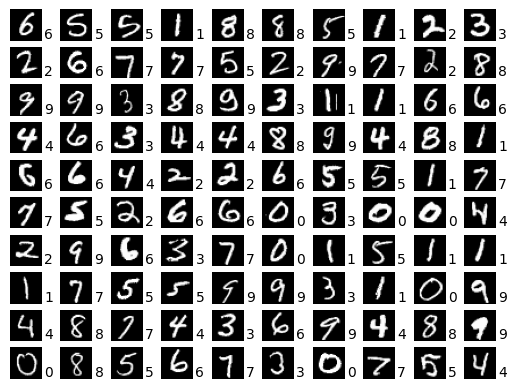

In [13]:
model = ConvNet1()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()

Epoch: 1, Idx: 0, Loss: 2.360789
Epoch: 1, Idx: 100, Loss: 0.132752
Epoch: 1, Idx: 200, Loss: 0.102224
Epoch: 1, Idx: 300, Loss: 0.296614
Epoch: 1, Idx: 400, Loss: 0.128925
Epoch: 1, Idx: 500, Loss: 0.100123
Epoch: 1, Idx: 600, Loss: 0.029676
Epoch: 1, Idx: 700, Loss: 0.009975
Epoch: 1, Idx: 800, Loss: 0.057376
Epoch: 1, Idx: 900, Loss: 0.016293

Test set: Average loss: 0.0396, Accuracy: 9870/10000 (98.70%)



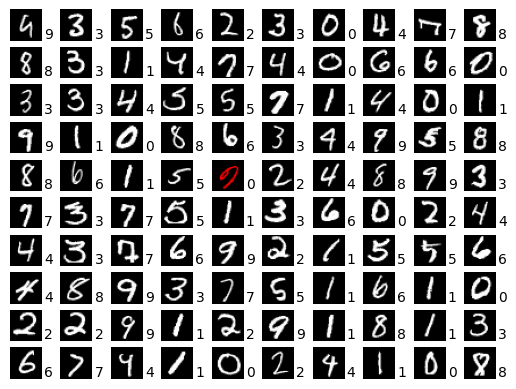

Epoch: 2, Idx: 0, Loss: 0.015049
Epoch: 2, Idx: 100, Loss: 0.005793
Epoch: 2, Idx: 200, Loss: 0.017739
Epoch: 2, Idx: 300, Loss: 0.032165
Epoch: 2, Idx: 400, Loss: 0.096393
Epoch: 2, Idx: 500, Loss: 0.013347
Epoch: 2, Idx: 600, Loss: 0.003267
Epoch: 2, Idx: 700, Loss: 0.008429
Epoch: 2, Idx: 800, Loss: 0.036682
Epoch: 2, Idx: 900, Loss: 0.005017

Test set: Average loss: 0.0329, Accuracy: 9897/10000 (98.97%)



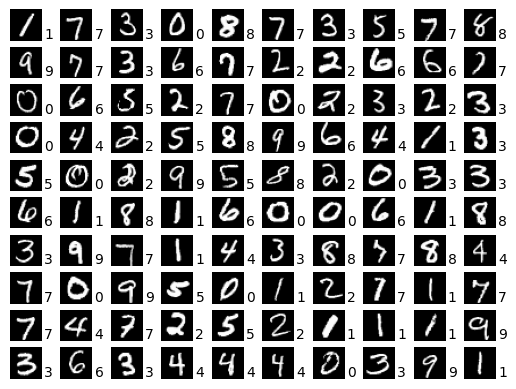

Epoch: 3, Idx: 0, Loss: 0.025796
Epoch: 3, Idx: 100, Loss: 0.025752
Epoch: 3, Idx: 200, Loss: 0.053219
Epoch: 3, Idx: 300, Loss: 0.032609
Epoch: 3, Idx: 400, Loss: 0.072766
Epoch: 3, Idx: 500, Loss: 0.052133
Epoch: 3, Idx: 600, Loss: 0.122656
Epoch: 3, Idx: 700, Loss: 0.040073
Epoch: 3, Idx: 800, Loss: 0.000759
Epoch: 3, Idx: 900, Loss: 0.000472

Test set: Average loss: 0.0290, Accuracy: 9915/10000 (99.15%)



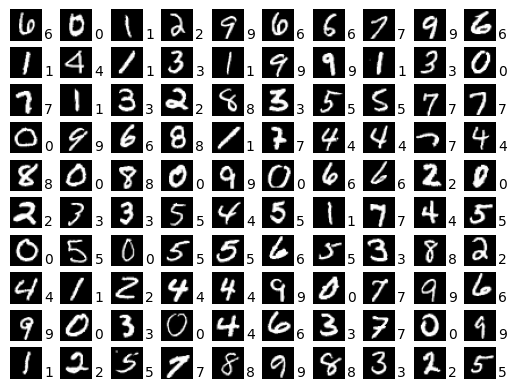

Epoch: 4, Idx: 0, Loss: 0.007341
Epoch: 4, Idx: 100, Loss: 0.000665
Epoch: 4, Idx: 200, Loss: 0.000909
Epoch: 4, Idx: 300, Loss: 0.013384
Epoch: 4, Idx: 400, Loss: 0.002075
Epoch: 4, Idx: 500, Loss: 0.005209
Epoch: 4, Idx: 600, Loss: 0.007327
Epoch: 4, Idx: 700, Loss: 0.001287
Epoch: 4, Idx: 800, Loss: 0.000166
Epoch: 4, Idx: 900, Loss: 0.014199

Test set: Average loss: 0.0284, Accuracy: 9919/10000 (99.19%)



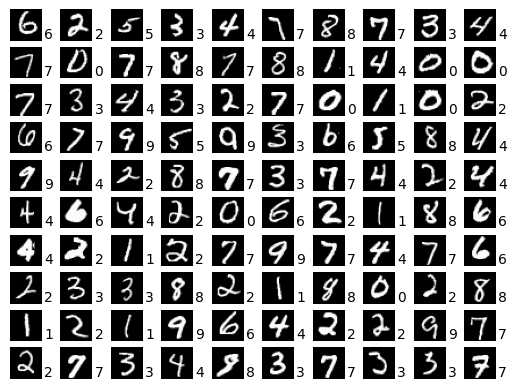

Epoch: 5, Idx: 0, Loss: 0.001463
Epoch: 5, Idx: 100, Loss: 0.013761
Epoch: 5, Idx: 200, Loss: 0.002809
Epoch: 5, Idx: 300, Loss: 0.001835
Epoch: 5, Idx: 400, Loss: 0.002681
Epoch: 5, Idx: 500, Loss: 0.007898
Epoch: 5, Idx: 600, Loss: 0.000310
Epoch: 5, Idx: 700, Loss: 0.001431
Epoch: 5, Idx: 800, Loss: 0.000208
Epoch: 5, Idx: 900, Loss: 0.000211

Test set: Average loss: 0.0273, Accuracy: 9919/10000 (99.19%)



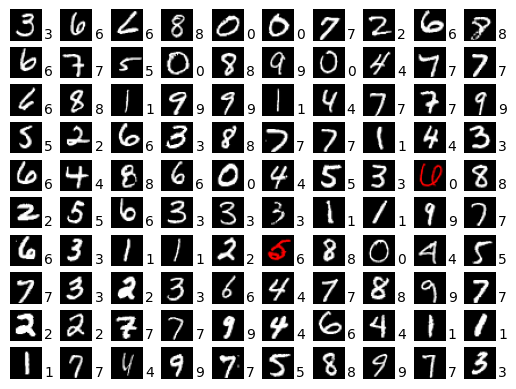

Epoch: 6, Idx: 0, Loss: 0.001662
Epoch: 6, Idx: 100, Loss: 0.001022
Epoch: 6, Idx: 200, Loss: 0.000558
Epoch: 6, Idx: 300, Loss: 0.001614
Epoch: 6, Idx: 400, Loss: 0.000355
Epoch: 6, Idx: 500, Loss: 0.002352
Epoch: 6, Idx: 600, Loss: 0.002541
Epoch: 6, Idx: 700, Loss: 0.000468
Epoch: 6, Idx: 800, Loss: 0.001359
Epoch: 6, Idx: 900, Loss: 0.000592

Test set: Average loss: 0.0274, Accuracy: 9925/10000 (99.25%)



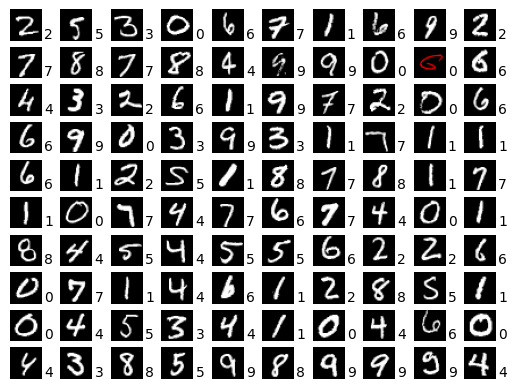

Epoch: 7, Idx: 0, Loss: 0.000346
Epoch: 7, Idx: 100, Loss: 0.000385
Epoch: 7, Idx: 200, Loss: 0.000656
Epoch: 7, Idx: 300, Loss: 0.000314
Epoch: 7, Idx: 400, Loss: 0.002370
Epoch: 7, Idx: 500, Loss: 0.001913
Epoch: 7, Idx: 600, Loss: 0.002891
Epoch: 7, Idx: 700, Loss: 0.002696
Epoch: 7, Idx: 800, Loss: 0.001094
Epoch: 7, Idx: 900, Loss: 0.000117

Test set: Average loss: 0.0283, Accuracy: 9921/10000 (99.21%)



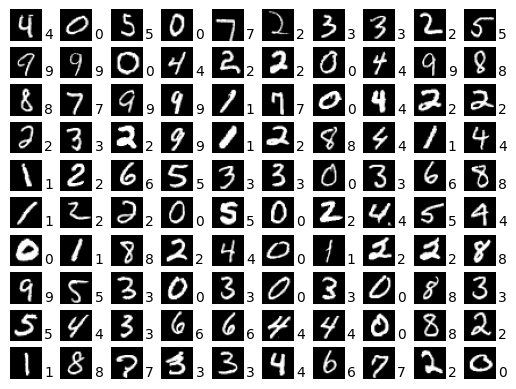

Epoch: 8, Idx: 0, Loss: 0.000418
Epoch: 8, Idx: 100, Loss: 0.000169
Epoch: 8, Idx: 200, Loss: 0.000055
Epoch: 8, Idx: 300, Loss: 0.001977
Epoch: 8, Idx: 400, Loss: 0.000160
Epoch: 8, Idx: 500, Loss: 0.001324
Epoch: 8, Idx: 600, Loss: 0.003789
Epoch: 8, Idx: 700, Loss: 0.000368
Epoch: 8, Idx: 800, Loss: 0.000853
Epoch: 8, Idx: 900, Loss: 0.000701

Test set: Average loss: 0.0285, Accuracy: 9918/10000 (99.18%)



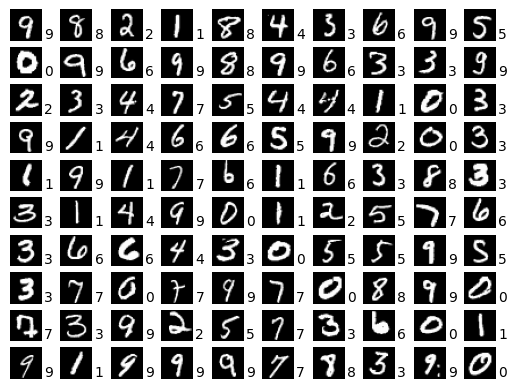

Epoch: 9, Idx: 0, Loss: 0.001074
Epoch: 9, Idx: 100, Loss: 0.000639
Epoch: 9, Idx: 200, Loss: 0.001297
Epoch: 9, Idx: 300, Loss: 0.000077
Epoch: 9, Idx: 400, Loss: 0.000681
Epoch: 9, Idx: 500, Loss: 0.000446
Epoch: 9, Idx: 600, Loss: 0.000372
Epoch: 9, Idx: 700, Loss: 0.000955
Epoch: 9, Idx: 800, Loss: 0.000170
Epoch: 9, Idx: 900, Loss: 0.000448

Test set: Average loss: 0.0283, Accuracy: 9915/10000 (99.15%)



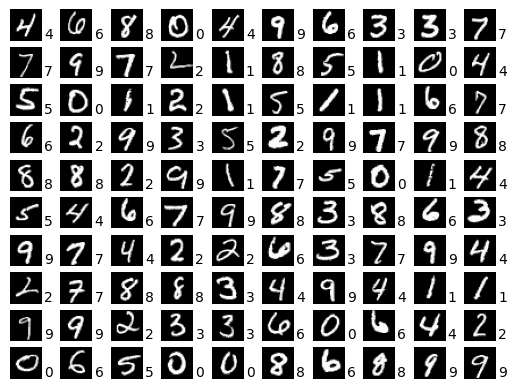

Epoch: 10, Idx: 0, Loss: 0.000205
Epoch: 10, Idx: 100, Loss: 0.000318
Epoch: 10, Idx: 200, Loss: 0.000855
Epoch: 10, Idx: 300, Loss: 0.002900
Epoch: 10, Idx: 400, Loss: 0.000274
Epoch: 10, Idx: 500, Loss: 0.000385
Epoch: 10, Idx: 600, Loss: 0.001096
Epoch: 10, Idx: 700, Loss: 0.000616
Epoch: 10, Idx: 800, Loss: 0.000867
Epoch: 10, Idx: 900, Loss: 0.000727

Test set: Average loss: 0.0290, Accuracy: 9923/10000 (99.23%)



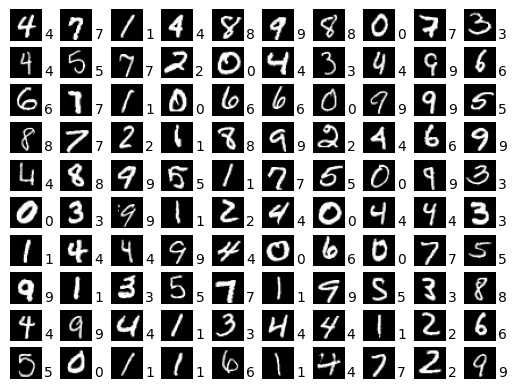

In [14]:
model = ConvNet3()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()